In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import LocalOutlierFactor
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from yellowbrick.classifier import ConfusionMatrix

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

In [21]:
# Load Steller data 
df=pd.read_csv('C:/Users/Mariam/Desktop/Maryam_Python/dsi_2022-02/star_classification.csv')

for x in ['redshift','u' ,'g','r' ,'i', 'z' ]:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan
    df = df.dropna(axis = 0)
    
# Encoding the categorical value of class 
df['class'] = df['class'].replace({'GALAXY': 0,
                                   'STAR'  : 1,
                                   'QSO'   : 2})

# split the class from other features
y = df["class"]
x = df.drop("class", axis=1)

# Applying SMOTE
smote = SMOTE(random_state=10)
print('Original dataset shape %s' % Counter(y))
x, y = smote.fit_resample(x, y)
print('Resampled dataset shape %s' % Counter(y))

# concatenate the features
df_1=pd.concat([x,y],axis=1)

Original dataset shape Counter({0: 59150, 1: 21506, 2: 9979})
Resampled dataset shape Counter({0: 59150, 2: 59150, 1: 59150})


In [22]:
df_1.drop(['obj_ID','run_ID','rerun_ID','cam_col','field_ID','spec_obj_ID','fiber_ID'],axis=1,inplace=True)

In [23]:
x = df_1.drop(['class'], axis=1)
y = df_1['class']
x_train , x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2022)

scaler = StandardScaler()
scaler.fit(x_train)
X_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
X_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

In [34]:
hidden_layer_sizes = []
for i in range(1, 11):
    size = (i,)
    hidden_layer_sizes.append(size)
hidden_layer_sizes

[(1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,)]

In [35]:
mlp_params = {
    'hidden_layer_sizes': hidden_layer_sizes,
    'activation': ['logistic', 'tanh'],
    'solver': ['adam', 'sgd'],
    'validation_fraction': [0.1, 0.2],
    'random_state': np.arange(0, 42)
}
randomized_search = RandomizedSearchCV(MLPClassifier(), param_distributions=mlp_params, n_iter=20, scoring='accuracy', cv=5, return_train_score=True)
randomized_search.fit(X_train, y_train)
best_params = randomized_search.best_params_

c:\Users\Mariam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
c:\Users\Mariam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
c:\Users\Mariam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
c:\Users\Mariam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
c:\Users\Mariam\

In [36]:
best_params

{'validation_fraction': 0.2,
 'solver': 'adam',
 'random_state': 19,
 'hidden_layer_sizes': (9,),
 'activation': 'tanh'}

In [37]:
MLPC= MLPClassifier(validation_fraction=best_params['validation_fraction'],
                    solver=best_params['solver'], random_state=best_params['random_state'],
                   hidden_layer_sizes = best_params['hidden_layer_sizes'],
                   activation=best_params['activation'])

In [25]:
#MLPC= MLPClassifier(validation_fraction=0.1,
                  #  solver='adam', random_state=33,
                  # hidden_layer_sizes = 8,
                 #  activation='tanh')

In [38]:
cross_validate_results = cross_validate(MLPC, X_train, y_train, scoring='accuracy', cv=5, return_train_score=True)
cross_validate_results

{'fit_time': array([32.19100046, 28.23499417, 28.08700418, 25.90701199, 28.31400037]),
 'score_time': array([0.01100016, 0.01100659, 0.01200199, 0.01099539, 0.00999928]),
 'test_score': array([0.96537757, 0.96361651, 0.9627712 , 0.96400394, 0.96449704]),
 'train_score': array([0.96439138, 0.96402156, 0.96421527, 0.96411841, 0.96473478])}

In [39]:
train_score = cross_validate_results['train_score'].mean() * 100
test_score = cross_validate_results['test_score'].mean() * 100
print(f'Train: {train_score}')
print(f'Test: {test_score}')

Train: 96.42962806424345
Test: 96.40532544378699


In [40]:
MLPC.fit(X_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(9,), random_state=19,
              validation_fraction=0.2)

In [41]:
predict = MLPC.predict(X_test)
predict

array([1, 2, 2, ..., 0, 0, 2], dtype=int64)

In [42]:
unique, counts = np.unique(predict, return_counts=True)

In [43]:
dict(zip(unique, counts))

{0: 12043, 1: 11933, 2: 11514}

In [44]:
print(classification_report(y_test, predict, digits=3))

              precision    recall  f1-score   support

           0      0.940     0.955     0.948     11861
           1      0.990     1.000     0.995     11817
           2      0.964     0.939     0.951     11812

    accuracy                          0.965     35490
   macro avg      0.965     0.965     0.965     35490
weighted avg      0.965     0.965     0.965     35490



In [45]:
classes = ['GALAXY','QSO','STAR']

c:\Users\Mariam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names


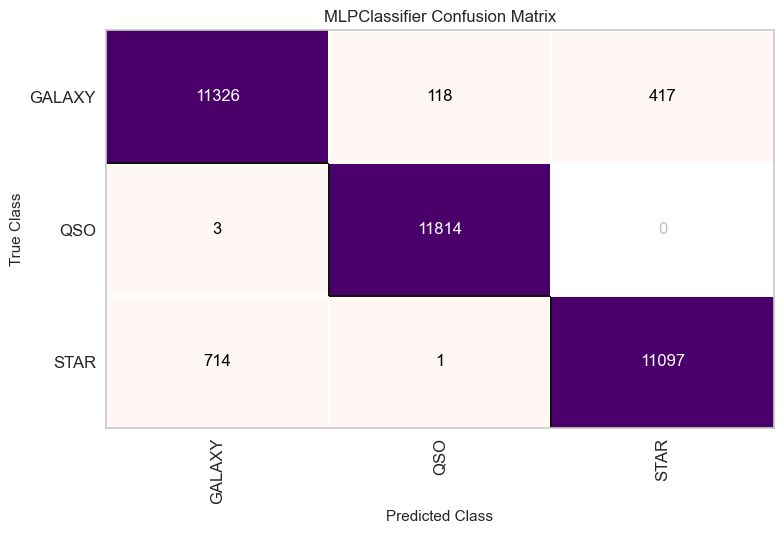

<AxesSubplot: title={'center': 'MLPClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [46]:
MLP_c = ConfusionMatrix(MLPC, classes=classes, cmap='RdPu')
MLP_c.fit(x_train, y_train)
MLP_c.score(X_test, y_test)
MLP_c.show()

In [47]:
mlp_gs = MLPClassifier(max_iter=50)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels


c:\Users\Mariam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=50), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [48]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [49]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
 print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.961 (+/-0.002) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'sgd'}
0.965 (+/-0.001) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'adam'}
0.961 (+/-0.001) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.965 (+/-0.001) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.951 (+/-0.001) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'sgd'}
0.963 (+/-0.001) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}
0.951 (+/-0.002) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.964 (+/-0.001) 

In [54]:

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     11861
           1       0.99      1.00      0.99     11817
           2       0.97      0.94      0.95     11812

    accuracy                           0.97     35490
   macro avg       0.97      0.97      0.97     35490
weighted avg       0.97      0.97      0.97     35490



c:\Users\Mariam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names


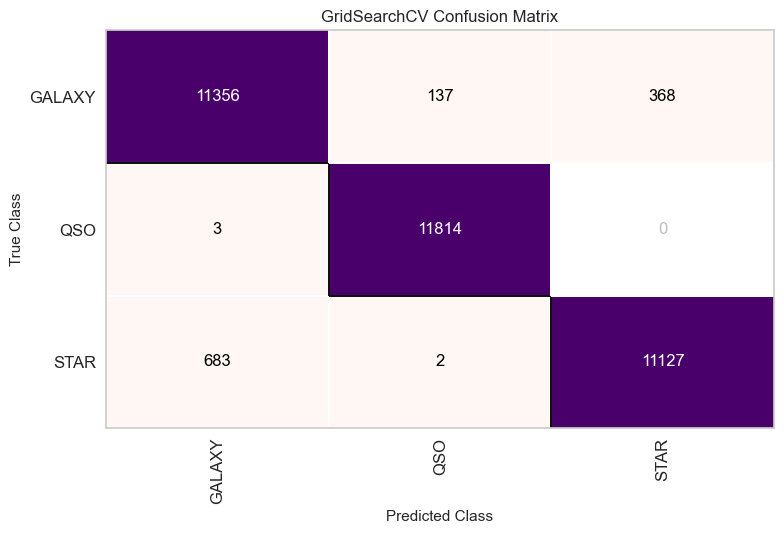

<AxesSubplot: title={'center': 'GridSearchCV Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [51]:
MLP_c = ConfusionMatrix(clf, classes=classes, cmap='RdPu')
MLP_c.fit(x_train, y_train)
MLP_c.score(X_test, y_test)
MLP_c.show()